In [1]:
import os
import albumentations as A
import matplotlib.pyplot as plt
from collections import deque
from PIL import Image
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

from dataset import PlantDataset

DATA_PATH = '../data/'

In [2]:
#training dataset
dataset_train = PlantDataset(set_dir='train').df
#testing dataset
dataset_valid = PlantDataset(set_dir='valid').df

# Mid-Level Fusion
### Extracting features with LBP: Local Binary Pattern

In [4]:
def ext_colored_features(path):
    # Load the image
    img = io.imread(path, as_gray=True)
    lbp_features = feature.local_binary_pattern(img, P=8, R=1.0, method='uniform')
    lbp_features = lbp_features.reshape((lbp_features.shape[0], -1))
    # Compute histogram of LBP values
    hist, _ = np.histogram(lbp_features.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2))
    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist
    
def ext_side_features(path):
    # Load the image
    img = io.imread(path)
    lbp_features = feature.local_binary_pattern(img, P=8, R=1.0, method='uniform')
    lbp_features = lbp_features.reshape((lbp_features.shape[0], -1))
    # Compute histogram of LBP values
    hist, _ = np.histogram(lbp_features.ravel(), bins=np.arange(0, 24 + 3), range=(0, 24 + 2))
    # Normalize histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

In [10]:
import numpy as np
from skimage import io, feature
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier 

#divide instances into training and testing 
X_train = dataset_train[["color_cam_path","side_cam_path"]]
y_train = dataset_train["Label"]
X_test = dataset_valid[["color_cam_path","side_cam_path"]]
y_test = dataset_valid["Label"]

features_lbp_color_tr = []
features_lbp_side_tr = []
features_lbp_color_ts = []
features_lbp_side_ts = []

# features_lbp_color_tr= [ext_colored_features(DATA_PATH + path) for path in X_train["color_cam_path"]]

for path in X_train["color_cam_path"]:
    features_lbp_color_tr.append(ext_colored_features(DATA_PATH + path))
for path in X_train["side_cam_path"]:
    features_lbp_side_tr.append(ext_side_features(DATA_PATH + path))
for path in X_test["color_cam_path"]:
    features_lbp_color_ts.append(ext_colored_features(DATA_PATH + path))
for path in X_test["side_cam_path"]:
    features_lbp_side_ts.append(ext_side_features(DATA_PATH + path))

# Train KNN classifier
knn_color = KNeighborsClassifier(n_neighbors=5)
knn_color.fit(features_lbp_color_tr, y_train)

# Predict labels for test set
y_pred = knn_color.predict(features_lbp_color_ts)

# Evaluate classifier performance
accuracy_color = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_color)

# Train KNN classifier
knn_side = KNeighborsClassifier(n_neighbors=5)
knn_side.fit(features_lbp_side_tr, y_train)

# Predict labels for test set
y_pred = knn_side.predict(features_lbp_side_ts)

# Evaluate classifier performance
accuracy_side = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_side)

fused_features_tr = np.concatenate([features_lbp_color_tr, features_lbp_side_tr], axis=1)
fused_features_ts = np.concatenate([features_lbp_color_ts, features_lbp_side_ts], axis=1)
# Train KNN classifier
knn_fused = KNeighborsClassifier(n_neighbors=5)
knn_fused.fit(fused_features_tr, y_train)

# Predict labels for test set
y_pred = knn_fused.predict(fused_features_ts)

# Evaluate classifier performance
accuracy_fused = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_fused)

    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Accuracy: 0.8873239436619719
Accuracy: 0.9456740442655935
Accuracy: 0.954728370221328


### Extracting features with ORB

In [14]:
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [11]:
def ORB_color(paths):
    des_list = []
    orb = cv2.ORB_create()
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        kp, des = orb.detectAndCompute(img, None)
        des_list.append((paths[i], des))
    return des_list


def ORB_side(paths):
    des_list = []
    orb = cv2.ORB_create()
    for i in range(0, len(paths)):
        img = cv2.imread(paths[i])
        kp, des = orb.detectAndCompute(img, None)
        des_list.append((paths[i], des))
    return des_list

In [12]:
def feature_extraction(des_list):
    # Convert the features into a numpy array
    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    # Convert into float
    descriptors_float = descriptors.astype(float)
    # Clustering the features
    centroids, variance = kmeans(descriptors_float, k_or_guess=35)
    # Create a histogram of features
    im_features = np.zeros((len(des_list), 35), "float32")
    for i in range(len(des_list)):
        words, distance = vq(des_list[i][1], centroids)
        for w in words:
            im_features[i][w] += 1
    return im_features

def train_and_classify(im_features, labels):
    ### Scaling the features
    scaler = StandardScaler().fit(im_features)
    im_features = scaler.transform(im_features)

    # Classify the images
    clf = SVC(kernel='linear', C=1, probability=True, max_iter=50).fit(im_features, labels)
    return clf

# Evaluate the model
list_of_accuracy = []
def evaluate_model(y_test, y_predict, method, dataset, list_of_accuracy):
    ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
    plt.show()
    accuracy_description = f"The accuracy score of {method} with {dataset} is {accuracy_score(y_test, y_predict)}"
    list_of_accuracy.append(accuracy_description)
    for i in list_of_accuracy:
        print(i)

In [20]:
# Model training using ORB with color cam
descriptors_color_ORB = ORB_color(X_train['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_ORB = feature_extraction(descriptors_color_ORB)
clf_color_ORB = train_and_classify(features_color_ORB, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=50).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


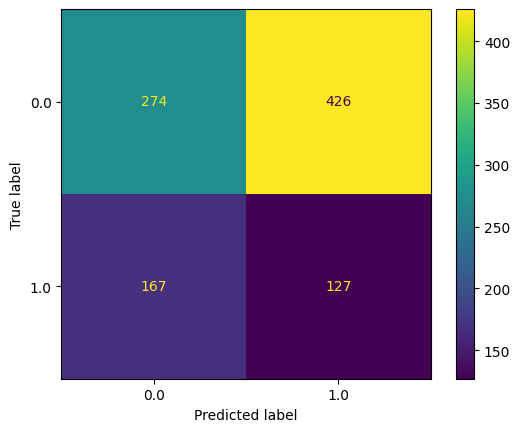

The accuracy score of ORB with color cam is 0.403420523138833


In [22]:
# model evaluation
descriptors_color_test_ORB = ORB_color(X_test['color_cam_path'].apply(lambda x: DATA_PATH + x).values.tolist())
features_color_test_ORB = feature_extraction(descriptors_color_test_ORB)
y_pred_color_ORB = clf_color_ORB.predict(features_color_test_ORB)
evaluate_model(y_test, y_pred_color_ORB, 'ORB', 'color cam', list_of_accuracy)

In [ ]:
#cgray.cc
#include <stream.h>
#include <String.h>
#include <stdlib.h>
#include <math.h>
void initab(int *, int, int);
int cgray(int *, int *, int *, int *)
int pos2(int *, int);
int even(Jut);
void fixepoint(int *, int,int,int);
void affichetab(int *, int);
int sometab(int *, int);
// call of function cgray from Splus
int cgray(int *x, int *point, int *n, int *k)
{
// calls :
// pos2, fixepoint, affichage,initab, sommetab,even
//
int fini,b;
fini=O;
//first time round call with x=c(O,O,...O)
if(sommetab(x,k)==O)
{
initab(x,k,O); //init of table to zero
x[O]=n;
//cout <<"\nfirst vector\t";
affichetab(x,k);
fixepoint(point,O,l,O); //fixes first (d,i,p)
return(O);
}
if(x[k-1]==n)
fini=l;
if(point[2]==O)
{
b=pos2(x,k); //index of second non zero element
if(b<=O)
{
//tout <<"erreur";
return(-l);
}
if(b==l)
{ if((point[O]==O)~&(x[O]==l))
fixepoint(point,O,1,1);
}
} //end p==O
}
else
{
if(even(n-x[O])) fixepoint
(point,O,l,1);
else if(!even(x[b])) fixepoint
(point,O,b,b);
else fixepoint(point,b,O,
point[2]);